In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from sklearn.preprocessing import minmax_scale


from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2023-10-05 15:18:47.560696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 15:18:47.683334: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 15:18:48.181108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-05 15:18:48.181184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
directory = '/home/bmis/Documents/AI-Workspace/ALS/Torgo/data'
data = pd.read_csv("/home/bmis/Documents/AI-Workspace/ALS/Torgo/data/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))

In [3]:
data.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)

In [4]:
def feature_extraction(df):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['filename'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)
            features.append(mean_mfcc)
        except EOFError:
            pass
        
    dataf = pd.DataFrame(features)
    dataf['class'] = df['is_dysarthria']
    return dataf

In [5]:
extratced_features = feature_extraction(data)

 30%|███████████▊                            | 593/2000 [00:08<00:18, 77.08it/s]/tmp/ipykernel_107263/1476600255.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  x , sr = librosa.load(record['filename'])
/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 78%|██████████████████████████████▏        | 1551/2000 [00:20<00:07, 60.59it/s]/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
 78%|██████████████████████████████▌        | 1565/2000 [00:20<00:07, 59.03it/s]/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=583
  war

In [6]:
extratced_features.loc[extratced_features['class']=='non_dysarthria','class'] = 0.0
extratced_features.loc[extratced_features['class']=='dysarthria','class'] = 1.0
extratced_features['class'] = extratced_features['class'].astype(float)

X = extratced_features.iloc[:,:-1].values
y = extratced_features.iloc[:,-1]

In [7]:
print(f'The total number of dataset is {X.shape[0]}')

The total number of dataset is 1999


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train = X_train.reshape(-1,16,8,1)
X_test = X_test.reshape(-1,16,8,1)
print(f'The training datset info is {X_train.shape} while test dataset is {X_test.shape}')
input_size = X_train.shape[1:]
print(f'The input to the model is of shape {input_size}')

The training datset info is (1599, 16, 8, 1) while test dataset is (400, 16, 8, 1)
The input to the model is of shape (16, 8, 1)


In [9]:
def autoencoder(input_size):

    inputs = Input(shape=input_size)
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    
    # Define the decoder
    decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(16, (3, 3), activation='relu')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(decoded)

    output = Flatten()(decoded)
    output = Dense(100, activation='relu')(output)
    output = Dense(1, activation='sigmoid')(output)
    
    # Create the autoencoder
    autoencoder = Model(inputs=inputs, outputs=output)

    return autoencoder

In [10]:
model = autoencoder(input_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 8, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 16, 8, 16)         160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 8)           1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 2, 8)           584   

2023-10-05 15:19:18.454623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 15:19:18.486365: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-10-05 15:19:18.486385: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-10-05 15:19:18.486735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model_name = "best_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose = 1, restore_best_weights=True)

In [13]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[checkpoint,earlystopping])

Epoch 1/50
43/45 [===========================>..] - ETA: 0s - loss: 0.6020 - accuracy: 0.6795
Epoch 1: val_loss improved from inf to 0.53281, saving model to best_model.h5
45/45 [==============================] - 1s 8ms/step - loss: 0.5966 - accuracy: 0.6831 - val_loss: 0.5328 - val_accuracy: 0.7437
Epoch 2/50
38/45 [========================>.....] - ETA: 0s - loss: 0.5500 - accuracy: 0.7237
Epoch 2: val_loss improved from 0.53281 to 0.49729, saving model to best_model.h5
45/45 [==============================] - 0s 5ms/step - loss: 0.5443 - accuracy: 0.7262 - val_loss: 0.4973 - val_accuracy: 0.7437
Epoch 3/50
44/45 [============================>.] - ETA: 0s - loss: 0.4809 - accuracy: 0.7635
Epoch 3: val_loss improved from 0.49729 to 0.48726, saving model to best_model.h5
45/45 [==============================] - 0s 5ms/step - loss: 0.4800 - accuracy: 0.7630 - val_loss: 0.4873 - val_accuracy: 0.7500
Epoch 4/50
43/45 [===========================>..] - ETA: 0s - loss: 0.4228 - accuracy: 0.

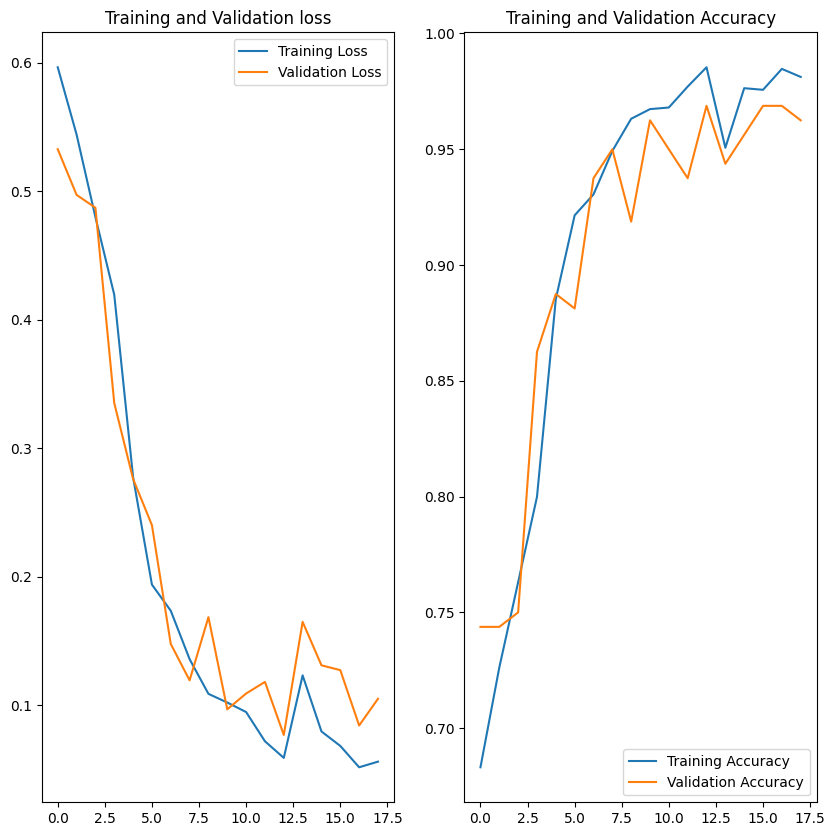

In [14]:
plt.figure(figsize=(10,10))

no_epochs = range(len(history.history['loss']))

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.subplot(1,2,1)

plt.plot(no_epochs , training_loss, label='Training Loss')
plt.plot(no_epochs , validation_loss , label='Validation Loss')
plt.legend(loc="upper right")
plt.title('Training and Validation loss')


plt.subplot(1,2,2)


plt.plot(no_epochs , training_accuracy, label='Training Accuracy')
plt.plot(no_epochs , validation_accuracy, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')


plt.show()

In [15]:
test_result = model.evaluate(X_test, y_test)
test_accuracy = test_result[1] * 100
test_loss = test_result[0]
print(f' The test accuracy is {test_accuracy}% while loss is {test_loss}')

13/13 [==============================] - 0s 2ms/step - loss: 0.0847 - accuracy: 0.9750
 The test accuracy is 97.50000238418579% while loss is 0.0846523568034172
